In [1]:
import requests
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

API_KEY = "67c490b3a3c78893272577xmvd2c31f"

def get_lat_lon(city, country="India"):
    """
    Fetches latitude and longitude for a given city using Geocode Maps.co API.

    Parameters:
    - city (str): Name of the city
    - country (str, optional): Country name (default: India)

    Returns:
    - tuple: (latitude, longitude) or (None, None) if not found
    """
    url = f"https://geocode.maps.co/search?q={city},{country}&format=json&api_key={API_KEY}"
    
    try:
        response = requests.get(url)
        response.raise_for_status()  
        data = response.json()

        if data:
            lat = float(data[0]["lat"])
            lon = float(data[0]["lon"])
            return lat, lon
        else:
            return None, None

    except requests.exceptions.RequestException as e:
        print(f"⚠ Error fetching data for {city}: {e}")
        return None, None



In [2]:
cities = [
    "Guwahati"
]

city_data = []
for city in cities:
    lat, lon = get_lat_lon(city)
    city_data.append({"City": city, "Latitude": lat, "Longitude": lon})
    time.sleep(1)

df_cities = pd.DataFrame(city_data)


In [3]:
df_cities

,City,Latitude,Longitude
0,Guwahati,26.180598,91.753943


In [6]:
def get_historical_weather(latitude, longitude, start_date, end_date):
    """
    Fetches historical daily weather data for a given location and date range.
    Includes mean relative humidity and implements retry logic if the API rate limit is exceeded.
    """
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "precipitation_sum,relative_humidity_2m_mean",
        "timezone": "auto"
    }

    while True:
        try:
            response = requests.get(base_url, params=params)
            if response.status_code == 429:
                print("Rate limit exceeded. Waiting 60 seconds before retrying...")
                time.sleep(60)
                continue
            
            response.raise_for_status()
            data = response.json()

            daily_df = pd.DataFrame({
                "Date": pd.to_datetime(data["daily"]["time"]),
                "Total Rainfall (mm)": data["daily"]["precipitation_sum"],
                "Mean Humidity (%)": data["daily"]["relative_humidity_2m_mean"],
            })

            return daily_df

        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}. Retrying in 60 seconds...")
            time.sleep(60)


In [7]:
import time
from tqdm import tqdm

start_date = "2015-01-01"
end_date = "2024-12-31"
weather_data = {}

for i in tqdm(range(df_cities.shape[0]), desc="Fetching Weather Data", unit="city"):  
    city = df_cities.iloc[i, 0] 
    latitude = df_cities.iloc[i, 1]  
    longitude = df_cities.iloc[i, 2]  

    try:
        weather_df = get_historical_weather(latitude, longitude, start_date, end_date)
        weather_data[city] = weather_df
    except requests.exceptions.HTTPError as e:
        print(f"Error fetching data for {city}: {e}")
    
    time.sleep(2)  # Wait for 2 seconds before making the next request


Fetching Weather Data: 100%|████████████████████| 1/1 [00:03<00:00,  3.49s/city]


In [8]:
weather_data

{'Guwahati':            Date  Total Rainfall (mm)  Mean Humidity (%)
 0    2015-01-01                  0.0                 69
 1    2015-01-02                  0.0                 69
 2    2015-01-03                  2.7                 72
 3    2015-01-04                  1.7                 85
 4    2015-01-05                  0.9                 78
 ...         ...                  ...                ...
 3648 2024-12-27                  0.0                 80
 3649 2024-12-28                  0.0                 82
 3650 2024-12-29                  0.0                 83
 3651 2024-12-30                  0.0                 80
 3652 2024-12-31                  0.0                 83
 
 [3653 rows x 3 columns]}

In [11]:
import os

output_dir = "/Users/user/Desktop/"
os.makedirs(output_dir, exist_ok=True)

# Save each city's weather data as a CSV file
for city, df in weather_data.items():
    file_path = os.path.join(output_dir, f"{city.replace(' ', '_')}_weather.csv")
    df.to_csv(file_path, index=False)
    print(f"Saved {city} data to {file_path}")

Saved Guwahati data to /Users/user/Desktop/Guwahati_weather.csv


In [12]:
df_gau_hr = pd.read_csv('/Users/user/Desktop/Guwahati_weather.csv')

In [13]:
df_gau_hr

,Date,Total Rainfall (mm),Mean Humidity (%)
0,2015-01-01,0.0,69
1,2015-01-02,0.0,69
2,2015-01-03,2.7,72
3,2015-01-04,1.7,85
4,2015-01-05,0.9,78
...,...,...,...
3648,2024-12-27,0.0,80
3649,2024-12-28,0.0,82
3650,2024-12-29,0.0,83
3651,2024-12-30,0.0,80


In [21]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)



Training model: 4 Neurons


4 Neurons: 100%|█████████████████████████████| 500/500 [00:01<00:00, 301.07it/s]


Best Test MSE for 4 Neurons: 3.22 at epoch 499

Training model: 8 Neurons


8 Neurons: 100%|█████████████████████████████| 500/500 [00:02<00:00, 216.08it/s]


Best Test MSE for 8 Neurons: 3.05 at epoch 495

Training model: 16 Neurons


16 Neurons: 100%|████████████████████████████| 500/500 [00:02<00:00, 223.37it/s]


Best Test MSE for 16 Neurons: 3.00 at epoch 495

Training model: 32 Neurons


32 Neurons:  86%|████████████████████████▏   | 432/500 [00:02<00:00, 205.68it/s]


Early stopping at epoch 432
Best Test MSE for 32 Neurons: 3.08 at epoch 382

Best model: 16 Neurons | Test MAE: 3.00


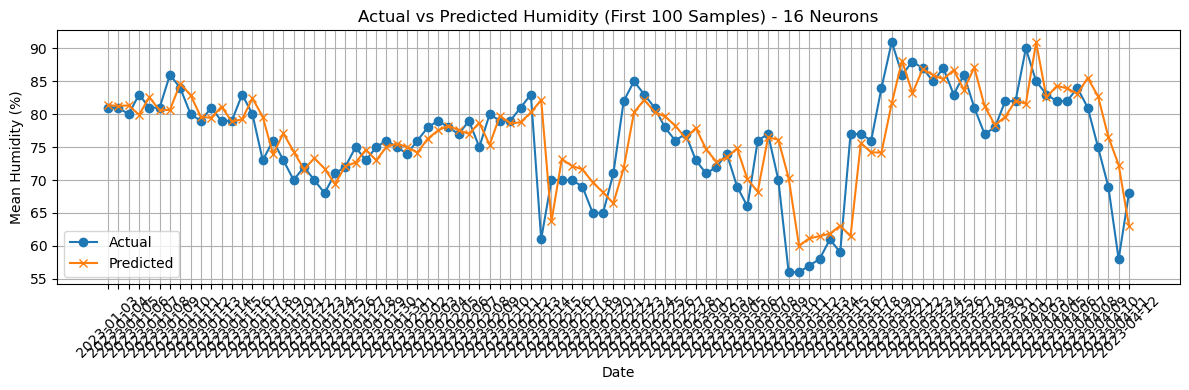

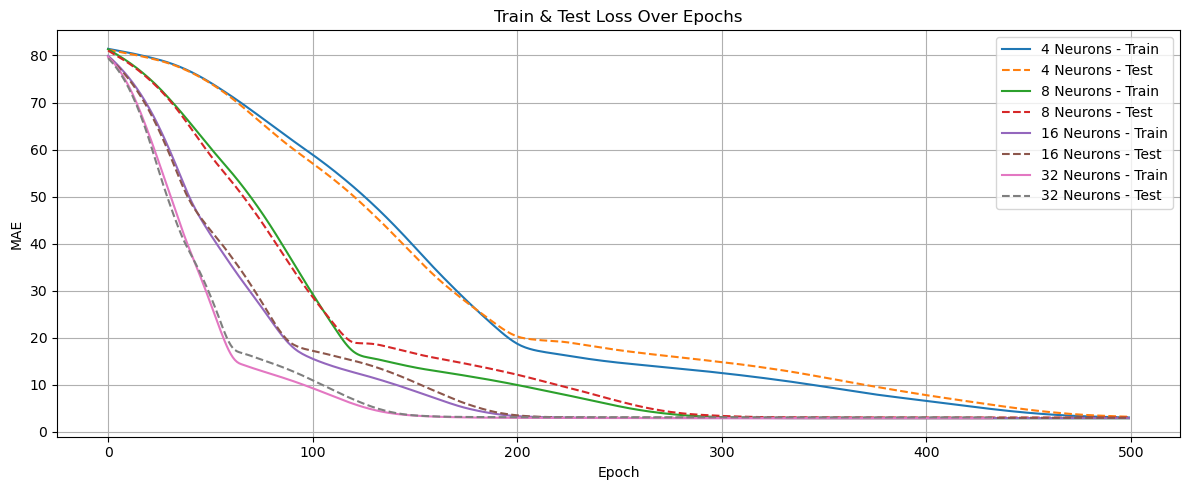

In [49]:


# --- 1. Load data ---
df = df_gau_hr.copy()
window_size = 7
humidity = df["Mean Humidity (%)"].values
temperature = df["Total Rainfall (mm)"].values

# --- 2. Create sliding window dataset ---
X, y = [], []
for i in range(len(df) - window_size - 1):
    h_win = humidity[i:i+window_size]
    t_win = temperature[i:i+window_size]
    features = np.concatenate([h_win, t_win])
    target = humidity[i + window_size]
    X.append(features)
    y.append(target)

X = np.array(X)
y = np.array(y)

# --- 3. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
dates = df["Date"].values[window_size + 1:]
dates_train, dates_test = train_test_split(dates, test_size=0.2, shuffle=False)

# --- 4. Scale inputs ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 5. Train with multiple model configs ---
model_configs = [
    {"name": "4 Neurons", "hidden_layer_sizes": (4,)},
    {"name": "8 Neurons", "hidden_layer_sizes": (8,)},
    {"name": "16 Neurons", "hidden_layer_sizes": (16, )},
    {"name": "32 Neurons", "hidden_layer_sizes": (32,)}
]

best_model = None
best_mse = float("inf")
best_config = None

# For plotting
all_train_losses = {}
all_test_losses = {}

# --- 6. Train each model with early stopping ---
for config in model_configs:
    print(f"\nTraining model: {config['name']}")

    model = MLPRegressor(
        hidden_layer_sizes=config["hidden_layer_sizes"],
        activation="relu",
        max_iter=1,
        warm_start=True,
        random_state=42
    )

    n_epochs = 500
    patience = 50
    no_improve = 0

    train_losses = []
    test_losses = []
    best_local_model = None
    best_local_mse = float("inf")
    best_epoch = 0

    for epoch in tqdm(range(n_epochs), desc=f"{config['name']}"):
        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        train_losses.append(train_mae)
        test_losses.append(test_mae)

        if test_mae < best_local_mse:  # Rename to best_local_mae if you want
            best_local_mse = test_mae
            best_local_model = copy.deepcopy(model)
            best_epoch = epoch
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    all_train_losses[config["name"]] = train_losses
    all_test_losses[config["name"]] = test_losses

    if best_local_mse < best_mse:
        best_mse = best_local_mse
        best_model = best_local_model
        best_config = config["name"]

    print(f"Best Test MSE for {config['name']}: {best_local_mse:.2f} at epoch {best_epoch}")

# --- 7. Final evaluation on best model ---
final_preds = best_model.predict(X_test_scaled)
print(f"\nBest model: {best_config} | Test MAE: {mean_absolute_error(y_test, final_preds):.2f}")

# --- 8. Plot actual vs predicted ---
plt.figure(figsize=(12, 4))
plt.plot(dates_test[:100], y_test[:100], label="Actual", marker='o')
plt.plot(dates_test[:100], final_preds[:100], label="Predicted", marker='x')
plt.title(f"Actual vs Predicted Humidity (First 100 Samples) - {best_config}")
plt.xlabel("Date")
plt.ylabel("Mean Humidity (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# --- 9. Plot train/test losses ---
plt.figure(figsize=(12, 5))
for name in all_train_losses:
    plt.plot(all_train_losses[name], label=f"{name} - Train")
    plt.plot(all_test_losses[name], label=f"{name} - Test", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Train & Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
print("Sample Predictions vs Actuals:")
for i in range(10):
    pred = round(y_pred[i], 2)
    actual = round(y_test[i], 2)
    diff = round(pred - actual, 2)
    print(f"Sample {i+1}: Predicted = {pred} | Actual = {actual} | Error = {diff}")


Sample Predictions vs Actuals:
Sample 1: Predicted = 83.0 | Actual = 81 | Error = 2.0
Sample 2: Predicted = 83.58 | Actual = 81 | Error = 2.58
Sample 3: Predicted = 82.53 | Actual = 80 | Error = 2.53
Sample 4: Predicted = 80.43 | Actual = 83 | Error = -2.57
Sample 5: Predicted = 82.96 | Actual = 81 | Error = 1.96
Sample 6: Predicted = 80.95 | Actual = 81 | Error = -0.05
Sample 7: Predicted = 81.39 | Actual = 86 | Error = -4.61
Sample 8: Predicted = 85.58 | Actual = 84 | Error = 1.58
Sample 9: Predicted = 83.7 | Actual = 80 | Error = 3.7
Sample 10: Predicted = 80.48 | Actual = 79 | Error = 1.48


In [51]:
# Extract scaler parameters
scaler_mean = scaler.mean_
scaler_std = scaler.scale_

# Extract MLP model weights and biases
weights = best_model.coefs_
biases = best_model.intercepts_


In [52]:
scaler_mean

array([81.08161866, 81.0877915 , 81.09430727, 81.0994513 , 81.09910837,
       81.10185185, 81.10356653,  6.75222908,  6.75349794,  6.75387517,
        6.75308642,  6.75250343,  6.75219479,  6.75233196])

In [53]:
scaler_std

array([ 8.8859288 ,  8.88378568,  8.88188508,  8.88096018,  8.88082886,
        8.88110674,  8.88099037, 12.55856781, 12.55807243, 12.55788608,
       12.5582129 , 12.55848693, 12.55864181, 12.55857025])

In [48]:
import json

# --- Save scaler parameters ---
scaler_params = {
    "mean": scaler.mean_.tolist(),
    "std": scaler.scale_.tolist()
}

with open("humidity_rainfall_scaler_params.json", "w") as f:
    json.dump(scaler_params, f, indent=2)

# --- Save MLP model weights and biases ---
mlp_params = {
    "weights": [w.tolist() for w in weights],
    "biases": [b.tolist() for b in biases]
}

with open("humidity_model_weights.json", "w") as f:
    json.dump(mlp_params, f, indent=2)
